# Introduction
This notebook contains examples how to use the Python bindings for Hybrid Genetic Search, provided as part of the [EURO Meets NeurIPS 2022 Vehicle Routing Competition](https://euro-neurips-vrp-2022.challenges.ortec.com/). It uses the code from https://github.com/ortec/euro-neurips-vrp-2022-quickstart/tree/python-bindings.

The notebook shows how to run the c++ HGS algorithm and contains some plotting tools. Additionally, it provides an example of how the bindings can be used to implement a variant of the Genetic algorithm in Python, which uses a Neural Network to predict which offspring candidate to use in the local search.

Special thanks to [Niels Wouda](https://github.com/N-Wouda) for providing the initial implementation of the Python bindings.

# Setup

## Environment
This notebook can run on colab, in which case it downloads the quickstart repo in the colab environment.

In [1]:
try:
    from google import colab
    colab = True
except ModuleNotFoundError:
    colab = False

In [2]:
import os
if colab:
    # The repo may already be cloned if the runtime was restarted
    if not os.path.isdir('euro-neurips-vrp-2022-quickstart'):
        !git clone --branch python-bindings https://github.com/ortec/euro-neurips-vrp-2022-quickstart.git
    !pip install wurlitzer
    %cd euro-neurips-vrp-2022-quickstart
    %ls

## Imports

In [3]:
import sys
import os
import time
import numpy as np
import pandas as pd
import functools
from copy import copy
import io
from wurlitzer import pipes

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import collections as matcoll
import matplotlib.ticker as mtick
from matplotlib.collections import PatchCollection, LineCollection
from matplotlib.patches import Rectangle

In [5]:
import tools
from baselines.hgs_vrptw import hgspy
vars(hgspy)

{'__name__': 'hgspy',
 '__doc__': None,
 '__package__': '',
 '__loader__': <_frozen_importlib_external.ExtensionFileLoader at 0x11b135fa0>,
 '__spec__': ModuleSpec(name='hgspy', loader=<_frozen_importlib_external.ExtensionFileLoader object at 0x11b135fa0>, origin='/Users/wouterko/dev/euro-neurips-vrp-2022-quickstart-dev/baselines/hgs_vrptw/lib/hgspy.cpython-39-darwin.so'),
 'Config': hgspy.Config,
 'Params': hgspy.Params,
 'Split': hgspy.Split,
 'LocalSearch': hgspy.LocalSearch,
 'Individual': hgspy.Individual,
 'Population': hgspy.Population,
 'Genetic': hgspy.Genetic,
 'Crossover': hgspy.Crossover,
 '__file__': '/Users/wouterko/dev/euro-neurips-vrp-2022-quickstart-dev/baselines/hgs_vrptw/lib/hgspy.cpython-39-darwin.so'}

## Plotting functions

In [6]:
def discrete_cmap(N, base_cmap=None):
    """
    Create an N-bin discrete colormap from the specified input map
    """
    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py
def plot_vrptw(ax1, instance, solution=None,
         dist=None, markersize=5, title="VRP", no_legend=False):
    """
    Plot the route(s) on matplotlib axis ax1.
    """
    coords = np.array(instance['coords'])
    demand = np.array(instance['demands'])
    capacity = instance['capacity']
    timew = np.array(instance['time_windows'])
    service_t = instance['service_times']
    dist = instance['duration_matrix']
    min_routes = demand.sum() / capacity
    
    visualize_nodes = True
    
    x_dep, y_dep = coords[0,:]
    ax1.plot(x_dep, y_dep, 'sk', markersize=markersize * 4)
    
    total_dist = 0

    if solution is None:
        if visualize_nodes:
            xs, ys = coords.transpose()
            # color=cmap(0)
            ax1.plot(xs, ys, 'o', mfc='black', markersize=markersize, markeredgewidth=0.0)
        ax1.set_title("{}, min {:.2f} routes".format(title, min_routes) if demand is not None else title)
    else:
        routes = solution

        cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
        qvs = []
        total_timewarp = 0
        for veh_number, r in enumerate(routes):
            color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order
            
            route_coords = coords[r, :]
            xs, ys = route_coords.transpose()

            if demand is not None:
                route_demands = demand[r]
                total_route_demand = sum(route_demands)
                assert total_route_demand <= capacity
            if visualize_nodes:
                # Use color of route such that for nodes in an individual route it is clear to which route they belong
                ax1.plot(xs, ys, 'o', mfc=color if len(routes) > 1 else 'black', markersize=markersize, markeredgewidth=0.0)

            r_with_depot = np.concatenate(([0], r))
            route_dist = dist[r_with_depot, np.roll(r_with_depot, -1, 0)].sum()
            total_dist += route_dist

            # Check timewindows 
            prev = 0
            t = timew[0][0]
            timewarp = 0
            for (x, y), n in zip(route_coords, r):
                l, u = timew[n]
                arr = t + service_t[prev] + dist[prev, n]
                t = max(arr, l)
                if t > u:
                    timewarp += t - u
                    t = u
                assert t <= u, f"Time window violated for node {n}: {t} is not in ({l, u})"

                prev = n
            t = t + service_t[prev] + dist[prev, 0]  # Return to depot
            _, u = timew[0]
            if t > u:
                timewarp += t - u
                t = u
            assert t <= u
            
            total_timewarp += timewarp

            # Assume VRP
            label = 'R{}, # {}, c {} / {}, d {:d}{}{}'.format(
                veh_number,
                len(r),
                total_route_demand,
                capacity,
                route_dist,
                ", t {:d}".format(t),
                ", TW {:d}".format(timewarp) if timewarp > 0 else "",
            )

            qv = ax1.quiver(
                xs[:-1],
                ys[:-1],
                xs[1:] - xs[:-1],
                ys[1:] - ys[:-1],
                scale_units='xy',
                angles='xy',
                scale=1,
                color=color,
                label=label,
                width=0.001,
                headlength=20,
                headwidth=12,
            )

            qvs.append(qv)
        title_timewarp = ", TIMEWARP {:d}".format(total_timewarp) if total_timewarp > 0 else ""
        title = '{}, {} routes (min {:.2f}), total distance {:d}{}'.format(title, len(routes), min_routes, total_dist, title_timewarp)
        ax1.set_title(title)
        if label is not None and not no_legend:
            ax1.legend(handles=qvs)

    return total_dist
    

def plot_timew(ax, timewi):
    """Plot number of locations/customers that can be delivered at any time during the day"""
    timewi = np.array(timewi)
    horizon = timewi[0, 1] - timewi[0, 0]
    frm, to = timewi[1:].T

    times = np.concatenate((timewi[0], frm, to))
    deltas = np.concatenate((np.zeros_like(timewi[0]), np.ones_like(frm), -np.ones_like(to)))
    order = np.argsort(times)
    times[order]

    ax.step(times[order], np.cumsum(deltas[order]), where='post')
    ax.set_xlim(timewi[0])

    avg = ((timewi[1:, 1] - timewi[1:, 0]).sum() / horizon).round(1)
    ax.set_xlabel('Time')
    ax.set_ylabel('Num locations')
    ax.set_title(f'Time windows over horizon (avg {avg})')


def plot_demands(ax, demand, capacity):
    """Plot demands CDF by sorting them"""
    ax.plot(sorted(demand))
    avg = np.mean(demand)
    stops_per_route = capacity / avg
    ax.set_title(f'Demands (avg {avg.round(1)}/{capacity} so {stops_per_route.round(1)} stops/route)')
    ax.set_xlabel('Nodes')
    ax.set_ylabel('Demand')
    ax.set_ylim([0, max(demand) + 1])


def plot_schedule(ax, instance, solution=None, markersize=5, title="VRP", tw_linewidth=2, no_legend=False):
    """
    Plot the route(s) schedule on matplotlib axis ax.
    On the x-axis, plot the cumulative distance
    On the y-axis, plot five lines:
    - dotted: cumulative cost/distance/driving time in route
    - dashed: cumulative driving time + service time in route
    - dense: current time: cumulative driving, waiting and service time, resetted by 'time warps'
    - small dash: latest possible time when doing time calculations in reverse starting at the end (possible forward time warps)
    - shading: cumulative demand/load (y-axis normalized to vehicle capacity)
    """
    
    coords = instance['coords']
    demand = instance['demands']
    capacity = instance['capacity']
    timew = instance['time_windows']
    service_t = instance['service_times']
    dist = instance['duration_matrix']
    min_routes = demand.sum() / capacity
    routes = solution
        
    visualize_nodes = True
    
    node_plot_data = []

    cmap = discrete_cmap(len(routes) + 2, 'nipy_spectral')
    qvs = []
    total_dist = 0
    cum_cost = 0
    total_timewarp = 0
    for veh_number, r in enumerate(routes):
        color = cmap(len(routes) - veh_number)  # Invert to have in rainbow order
        
        route_coords = coords[r, :]
        xs, ys = route_coords.transpose()

        route_demands = demand[r]
        total_route_demand = sum(route_demands)
        assert total_route_demand <= capacity

        r_with_depot = np.concatenate(([0], r))
        route_dist = dist[r_with_depot, np.roll(r_with_depot, -1, 0)].sum()
        
        prev = 0
        assert service_t[0] == 0
        horizon = timew[0][1] - timew[0][0]
        t = timew[0][0]
        cum_demand = 0
        route_cost = 0
        cum_service = 0
        timewarp = 0
        route_plot_data = [(cum_cost, t, route_cost + cum_service, cum_demand)]
        for (x, y), n, d in zip(route_coords, r, route_demands):
            l, u = timew[n]
            arr = t + service_t[prev] + dist[prev, n]
            t = max(arr, l)
            cum_cost += dist[prev, n]
            route_cost += dist[prev, n]
            cum_demand += d
            cum_service += service_t[n]
            
            if t > u:
                timewarp += t - u
                print('node', n, 'timewarp', timewarp)
                t = u
            
            assert t <= u, f"Time window violated for node {n}: {t} is not in ({l, u})"
            assert cum_demand <= capacity
            
            # Add timewindow line
            node_plot_data.append((
                [(cum_cost, l), (cum_cost, u)],  # Timewindow
                'k' if (u - l) < horizon / 2 else 'gray', # Timewindow color
                [(cum_cost, t), (cum_cost, t + service_t[n])],  # Service window
                color, # Service window color
                [(cum_cost, arr), (cum_cost, t)] if arr > t else None
            ))
            
            route_plot_data.append((cum_cost, arr, route_cost + cum_service - service_t[n], cum_demand - d))
            route_plot_data.append((cum_cost, t + service_t[n], route_cost + cum_service, cum_demand))
            
            prev = n
        
        t = t + service_t[prev] + dist[prev, 0]  # Return to depot
        cum_cost += dist[prev, 0]
        route_cost += dist[prev, 0]
        _, u = timew[0]
        if t > u:
            timewarp += t - u
            t = u
        assert t <= u
        total_timewarp += timewarp
        
        route_plot_data.append((cum_cost, t, route_cost + cum_service - service_t[0], cum_demand))
        
        xs, ys, ys_exclwait, ys_demand = zip(*route_plot_data)
        ax.plot(xs, ys, color=color)
        ax.plot([cum_cost - route_cost, cum_cost], [0, route_cost], color=color, linestyle=':') # Cumulative cost only (excl service & waiting)
        ax.plot(xs, ys_exclwait, color=color, linestyle='-.')  # Cumulative cost + service time (excl waiting)
        # Scale demand to plot between 0 and 100 %
        ys_demand = np.array(ys_demand) / capacity * horizon
        ax.fill_between(xs, ys_demand, color=color, alpha=0.1)
        
        # Do the same thing in reverse to find last possibility
        t = timew[0][1]
        nxt = 0
        cum_cost_rev = cum_cost
        reverse_timewarp = 0
        route_plot_data = [(cum_cost_rev, t)]
        for (x, y), n, d in reversed(list(zip(route_coords, r, route_demands))):
            l, u = timew[n]
            dep = t - dist[n, nxt] # latest departure
            t = min(dep - service_t[n], u) # latest time to start service = latest arrival
            cum_cost_rev -= dist[n, nxt]
            if t < l:
                reverse_timewarp += l - t
                t = l
            assert t >= l, f"Time window violated for node {n}: {t} is not in ({l, u})"
            
            route_plot_data.append((cum_cost_rev, dep))
            route_plot_data.append((cum_cost_rev, t))
            
            nxt = n
        
        t = t - dist[0, nxt]
        l, _ = timew[0]
        if t < l:
            reverse_timewarp += l - t
            t = l
        assert t >= l
        assert timewarp == reverse_timewarp
        cum_cost_rev -= dist[0, nxt]
        route_plot_data.append((cum_cost_rev, t + service_t[0]))
    
        xs, ys = zip(*route_plot_data)
        ax.plot(xs, ys, color=color, linestyle='--')
        
        total_dist += route_dist
    
    timew = np.array(timew)
    
    timew_lines, timew_colors, node_service_lines, node_service_colors, timewarps = zip(*node_plot_data)
    timewarps = [tw for tw in timewarps if tw is not None]
    
    linecoll_tw = matcoll.LineCollection(timew_lines, colors=timew_colors, linewidths=tw_linewidth)
    linecoll_timewarps = matcoll.LineCollection(timewarps, colors='red', linewidths=tw_linewidth / 2, alpha=0.7) 
    
    ax.add_collection(linecoll_tw)
    ax.add_collection(linecoll_timewarps)
    
    ax.set_xlim([0, total_dist])
    ax.set_ylim(timew[0])
    ax.set_xlabel('Distance')
    ax.set_ylabel('Time')
    ax.set_title(title)

# Test a run of HGS using Python interface
We will read an instance, make some plots of its properties and test a run with HGS through the Python interface.

## Read (and plot) instance

In [7]:
instance_name = 'ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35'
instance = tools.read_vrplib(os.path.join('instances', f'{instance_name}.txt'))
{
    k: v.shape if isinstance(v, np.ndarray) else None
    for k, v in instance.items()
}

{'is_depot': (459,),
 'coords': (459, 2),
 'demands': (459,),
 'capacity': None,
 'time_windows': (459, 2),
 'service_times': (459,),
 'duration_matrix': (459, 459)}

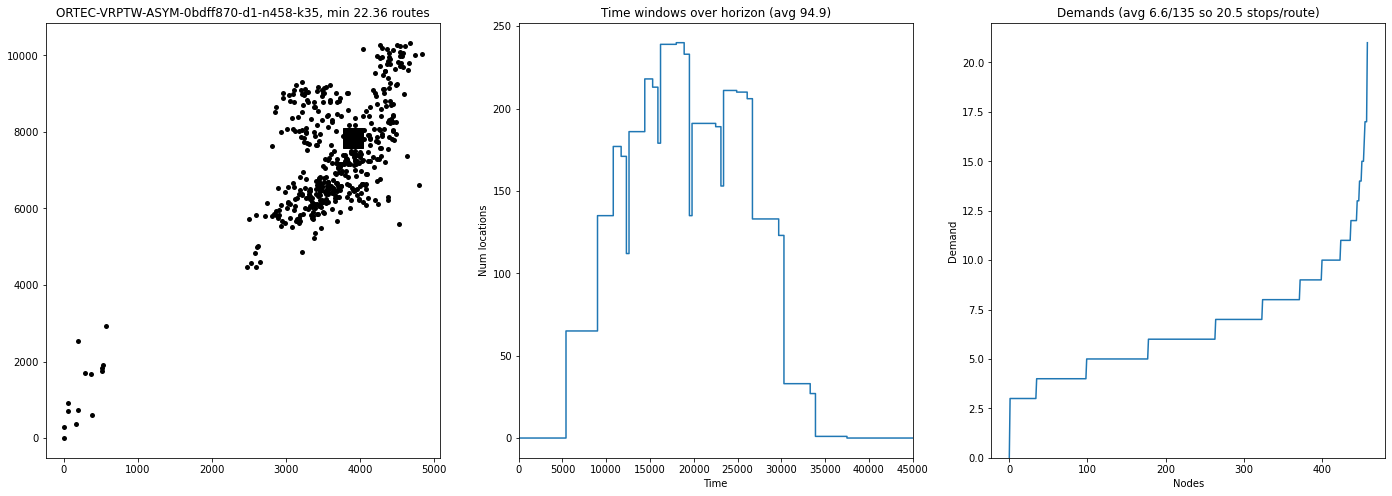

In [8]:
# Plot the instance nd some properties
fig, ax = plt.subplots(1, 3, figsize=(24, 8))
plot_vrptw(ax[0], instance, title=instance_name)
plot_timew(ax[1], instance['time_windows'])
plot_demands(ax[2], instance['demands'], instance['capacity'])

## Setup config and run HGS

In [9]:
def to_giant_tour_str(routes, with_depot=True):
    return " ".join(map(str, tools.to_giant_tour(routes, with_depot)))

# Trivial initial solution: one route per request
initial_solution = [[i] for i in range(1, instance['coords'].shape[0])]

# Define configuration
config = hgspy.Config(
    seed=1234, 
    nbVeh=-1,
    timeLimit=10,
    useWallClockTime=True,
    initialSolution=to_giant_tour_str(initial_solution),
    useDynamicParameters=True)

# Convert instance so it is suitable for HGS and define params object
params = hgspy.Params(config, **tools.inst_to_vars(instance))

split = hgspy.Split(params)
ls = hgspy.LocalSearch(params)
pop = hgspy.Population(params, split, ls)
algo = hgspy.Genetic(params, split, pop, ls)
algo.run()
best = pop.getBestFound()

# Avoid mixing up cpp and python output
sys.stdout.flush()
print("----- Solution -----")
# Print cost and routes of best solution
print("Cost: ", best.cost)
for i, route in enumerate(best.routes):
    print(f"Route {i}:", route)

----- HasLargeRoutes: 0, HasLargeTW: 0
Added initial solution to population
It     -1     -1 | T(s) 0.03 | Feas 1 1833647.00 1833647.00 | NO-INFEASIBLE | Div nan -1.00 | Feas 1.00 1.00 | Pen 394.67 1.00
Generated 5 individuals using Nearest
It     -1     -1 | T(s) 0.23 | Feas 1 1833647.00 1833647.00 | Inf 5 283362.00 293017.40 | Div nan 0.63 | Feas 1.00 0.95 | Pen 394.67 1.00
Generated 5 individuals using Furthest
It     -1     -1 | T(s) 0.46 | Feas 2 299023.00 1066335.00 | Inf 10 283362.00 296290.70 | Div 0.95 0.62 | Feas 1.00 0.90 | Pen 394.67 1.00
Generated 5 individuals using Sweep
It     -1     -1 | T(s) 0.60 | Feas 3 291232.00 807967.33 | Inf 15 283362.00 295020.20 | Div 0.82 0.61 | Feas 1.00 0.85 | Pen 394.67 1.00
Generated 85 individuals Randomly
It     -1     -1 | T(s) 3.92 | Feas 26 286526.00 297650.56 | Inf 57 283362.00 289525.56 | Div 0.59 0.56 | Feas 1.00 0.02 | Pen 394.67 1.00
It      0      2 | T(s) 3.93 | Feas 26 286526.00 297650.56 | Inf 58 283391.40 289269.67 | Div 0.

## Plot solution

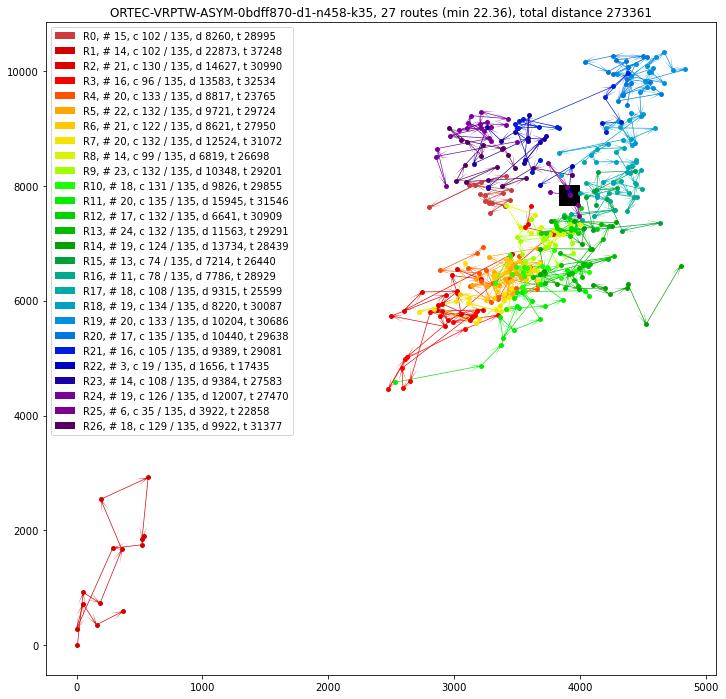

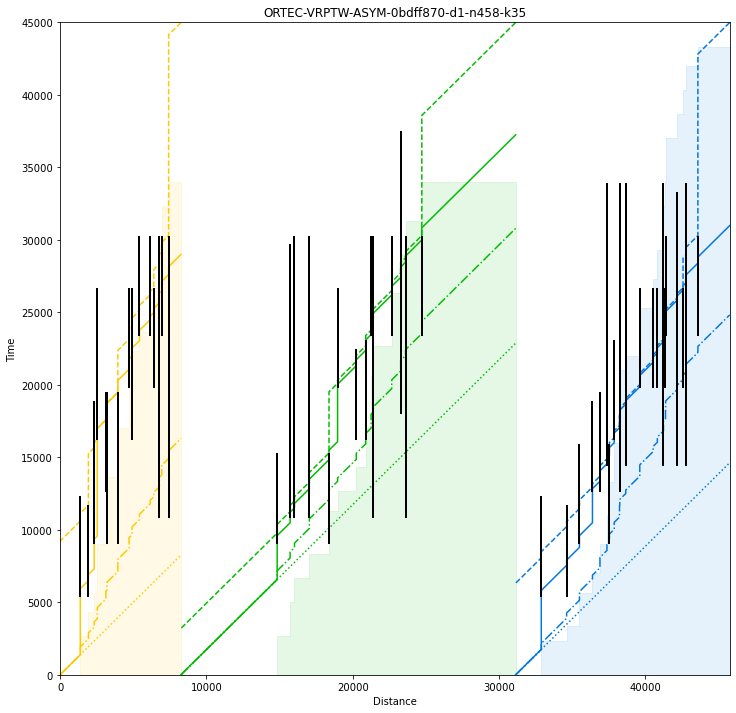

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
total_dist = plot_vrptw(ax, instance, [np.array(route) for route in best.routes], title=instance_name)
assert total_dist == best.cost

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
# Plot schedule for 3 routes to keep it clean
plot_schedule(ax, instance, [np.array(route) for route in best.routes[:3]], title=instance_name)

# Genetic algorithm in Python
In this part we implement some parts of the HGS algorithm in Python, such that they can be easily adapted. Since most of the computational effort is in the local search, using Python for the genetic algorithm has very little impact on the overall speed of the algorithm. This is an exact reimplementation of the C++ version of the code and should give the same results (except for speed).
* The computation of correlated vertices. This determines which pairs of nodes are tried for local search operators (SWAP, 2OPT, etc.) in the local search. Less correlated vertices may improve the speed but reduce the quality of the local search.
* The population with a Python based implementation of the binary tournament such that other selection strategies can be tried. Note that it uses the C++ implementation of biasedFitness for performance reasons.
* The genetic algorithm with multiple components implemented in Python:
    * The creation of the initial solutions in the pool. Since an `hgspy.Individual` can be instantiated using the constructor `__init__(self: hgspy.Individual, params: hgspy.Params, routes: List[List[int]]) -> None` it is easy to add Python based strategies.
    * The crossover strategy using the best of multiple (C++ implemented) crossovers. Note however that the crossover is not the bottleneck in time, so a simple Python implemented crossover may be an alternative.
    * The schedule/strategy for growing the neighborhood and population size. This can thus easily be adapted.

## Correlated vertices

In [11]:
# We can also set the correlated vertices which affect the local search from Python
# This implementation exactly reproduces the c++ implementation
# Important: when using a growing neighborhood, this function must also be called
# inside the genetic algorithm which is only possible using the Python implementation below
def get_correlated_vertices(instance, k=40, weight_waittime=0.2, weight_timewarp=1.0, symmetric=False):
    timewi = instance['time_windows']
    earliest, latest = timewi.transpose()
    service = instance['service_times']
    durations = instance['duration_matrix']
    proximity = (durations + np.minimum(
        weight_waittime * np.maximum(earliest[None, :] - durations - service[:, None] - latest[:, None], 0)
        + weight_timewarp * np.maximum(earliest[:, None] + service[:, None] + durations - latest[None, :], 0),
        weight_waittime * np.maximum(earliest[:, None] - durations - service[None, :] - latest[None, :], 0)
        + weight_timewarp * np.maximum(earliest[None, :] + service[None, :] + durations - latest[:, None], 0)
    ))[1:, 1:] # Skip depot

    # Create adjacency matrix for topk, masking self and depot by adding large constant
    # we add the index with a very small weight as tie-breaker to get same results as c++
    n = len(proximity)
    rng = np.arange(n)
    mask = np.eye(n, dtype=bool)
    adj = np.zeros_like(mask)
    adj[rng[:, None], np.argpartition(np.where(mask, 1e9, proximity + 1e-6 * rng[None, :]), k, -1)[:, :k]] = 1

    if symmetric:
        adj = adj | adj.transpose()
    
    return [[]] + [(np.flatnonzero(row) + 1).tolist() for row in adj]


# Test function (create new params object since correlatedVertices may change)
params = hgspy.Params(config, **tools.inst_to_vars(instance))
correlated_vertices = get_correlated_vertices(instance, params.config.nbGranular, params.proximityWeightWaitTime, params.proximityWeightTimeWarp, params.config.useSymmetricCorrelatedVertices)
assert(params.correlatedVertices == correlated_vertices)

----- HasLargeRoutes: 0, HasLargeTW: 0


## Population

In [12]:
MY_EPSILON = 1e-6

class Population(hgspy.Population):

    def __init__(self, params, split, local_search):
        super().__init__(params, split, local_search)
        self.params = params

    def get_random_individual(self):
        return self[self.params.rng() % len(self)]

    def get_binary_tournament(self, update_biased_fitness=True):
        # Before calling indiv.biasedFitness, we must update biased fitnesses
        # unless we know externally that nothing has changed, in which case we can pass
        # update_biased_fitness=False
        # (note: better solution would be to do this automatically/lazily)
        if update_biased_fitness:
            self.updateAllBiasedFitnesses()
        indiv1 = self.get_random_individual()
        indiv2 = self.get_random_individual()
        return (indiv1 if indiv1.biasedFitness < indiv2.biasedFitness else indiv2)

    def get_non_identical_parents_binary_tournament(self, use_cpp_impl=True):
        if use_cpp_impl:
            # Identical implementation in c++ 
            return self.getNonIdenticalParentsBinaryTournament()

        # Python implementation (for easy adaptation)
        parent1 = self.get_binary_tournament()
        parent2 = self.get_binary_tournament(update_biased_fitness=False)
        num_tries = 1
        while (parent1.brokenPairsDistance(parent2) < MY_EPSILON and num_tries < 10):
            parent2 = self.get_binary_tournament(update_biased_fitness=False)
            num_tries += 1

        return (parent1, parent2)

    def __getitem__(self, key):
        return self.get(int(key))

    def __len__(self):
        return self.size()

    def __iter__(self):
        return (self[i] for i in range(len(self)))

    def __repr__(self):
        # Bit hacky but it works
        out = io.StringIO()
        with pipes(stdout=out, stderr=sys.stderr):
            self.printState(0, 0)
        return "|".join(out.getvalue().split("|")[2:]).strip()

## Genetic algorithm

In [13]:
def get_best_of_srex_and_ox_crossovers(crossover, parent1, parent2):
    ox_offspring = crossover.OX(parent1, parent2)
    offspring1, offspring2 = crossover.SREX(parent1, parent2)
    srex_offspring = (
        offspring1 
        if offspring1.cost < offspring2.cost
        else offspring2
    )
    return (
        srex_offspring
        if srex_offspring.cost < ox_offspring.cost
        else ox_offspring
    )

class Genetic(object):
    
    def __init__(self, params):
        self.params = params
        self.split = hgspy.Split(params)
        self.crossover = hgspy.Crossover(params, self.split)
        self.local_search = hgspy.LocalSearch(params)
        # self.population = hgspy.Population(params, self.split, self.local_search)
        self.population = Population(params, self.split, self.local_search)

        # To exactly reproduce the c++ implementation we generate 
        # 4 individuals here that normally populate the candidate offspring array
        # (to advance the params.rng() number generator to the same state)
        for i in range(4):
            indiv = hgspy.Individual(params, True)
    
    def do_local_search_and_add_individual(self, indiv):
        params = self.params
        self.local_search.run(indiv, params.penaltyCapacity, params.penaltyTimeWarp)

        is_new_best = self.population.addIndividual(indiv, True)
        if (not indiv.isFeasible and params.rng() % 100 < params.config.repairProbability):
            self.local_search.run(indiv, params.penaltyCapacity * 10, params.penaltyTimeWarp * 10)
            if (indiv.isFeasible):
                is_new_best = self.population.addIndividual(indiv, False) or is_new_best
        return is_new_best

    def initialize_population(self):
        params = self.params

        if (params.nbClients == 1):
            # Quickly generate the one solution
            indiv = hgspy.Individual(params, True)
            self.split.generalSplit(indiv, params.nbVehicles)
            self.population.addIndividual(indiv, True)
            return

        if params.config.initialSolution != "":
            indiv = hgspy.Individual(params, params.config.initialSolution)
            self.population.addIndividual(indiv, True)
            self.log("Added initial solution to population")
            self.log(self.population)

        fractionGeneratedNearest = params.config.fractionGeneratedNearest
        fractionGeneratedFurthest = params.config.fractionGeneratedFurthest
        fractionGeneratedSweep = params.config.fractionGeneratedSweep
        fractionGeneratedRandomly = params.config.fractionGeneratedRandomly
        minSweepFillPercentage = params.config.minSweepFillPercentage
        maxToleratedCapacityViolation = params.config.maxToleratedCapacityViolation
        maxToleratedTimeWarp = params.config.maxToleratedTimeWarp
        initialTimeWarpPenalty = params.config.initialTimeWarpPenalty

        nofIndividuals = 4 * params.config.minimumPopulationSize

        # This penalty may be used by the construction heuristics
        params.penaltyTimeWarp = initialTimeWarpPenalty
        
        # Generate individuals using Nearest/Furthest
        for (useFurthest, nIndividuals) in (
            (False, round(fractionGeneratedNearest * nofIndividuals)),
            (True, round(fractionGeneratedFurthest * nofIndividuals)),
            ):
            for i in range(nIndividuals):
                indiv = hgspy.Individual(params, False)
                toleratedCapacityViolation = 0 if i == 0 else params.rng() % (maxToleratedCapacityViolation + 1)
                toleratedTimeWarp = 0 if i == 0 else params.rng() % (maxToleratedTimeWarp + 1)
                indiv = hgspy.Individual(params, False)
                self.local_search.constructIndividualWithSeedOrder(
                    toleratedCapacityViolation, toleratedTimeWarp, useFurthest, indiv)
                self.do_local_search_and_add_individual(indiv)

            self.log(f"Generated {nIndividuals} individuals using {'Furthest' if useFurthest else 'Nearest'}")
            self.log(self.population)

        # Generate individuals using Sweep
        nIndividuals = round(fractionGeneratedSweep * nofIndividuals)
        for i in range(nIndividuals):
            fillPercentage = 100 if i == 0 else minSweepFillPercentage + params.rng() % (100 - minSweepFillPercentage + 1)
            indiv = hgspy.Individual(params, False)
            self.local_search.constructIndividualBySweep(fillPercentage, indiv)
            self.do_local_search_and_add_individual(indiv)

        self.log(f"Generated {nIndividuals} individuals using Sweep")
        self.log(self.population)

        # Generate individuals by Splitting random permutations
        nIndividuals = round(fractionGeneratedRandomly * nofIndividuals)
        for i in range(nIndividuals):
            indiv = hgspy.Individual(params, True)
            self.split.generalSplit(indiv, params.nbVehicles)
            self.do_local_search_and_add_individual(indiv)

        self.log(f"Generated {nIndividuals} individuals Randomly")
        self.log(self.population)
    
    def get_offspring(self):
        parent1, parent2 = self.population.get_non_identical_parents_binary_tournament()
        return get_best_of_srex_and_ox_crossovers(self.crossover, parent1, parent2)

    def run(self, start_time=None):

        params = self.params
        config = params.config

        if start_time is None:
            start_time = time.time()

        self.initialize_population()
        
        nb_iter = 0
        nb_iter_non_prod = 1
        while (nb_iter_non_prod <= config.nbIter and (config.timeLimit is None or (time.time() - start_time < config.timeLimit))):
            
            # SELECTION AND CROSSOVER
            offspring = self.get_offspring()
            
            # LOCAL SEARCH
            is_new_best = self.do_local_search_and_add_individual(offspring)
            # TRACKING THE NUMBER OF ITERATIONS SINCE LAST SOLUTION IMPROVEMENT
            nb_iter_non_prod = 1 if is_new_best else (nb_iter_non_prod + 1)

            # DIVERSIFICATION, PENALTY MANAGEMENT AND TRACES
            if (nb_iter % 100 == 0):
                self.population.managePenalties()
            if (nb_iter % 500 == 0):
                self.log(self.format_state(self.population, nb_iter, nb_iter_non_prod, start_time))

            # FOR TESTS INVOLVING SUCCESSIVE RUNS UNTIL A TIME LIMIT: WE RESET THE ALGORITHM/POPULATION EACH TIME max_iter_non_prod IS ATTAINED
            if (config.timeLimit is not None and nb_iter_non_prod == config.nbIter and config.doRepeatUntilTimeLimit):
                self.log("----- RESET: CREATING A NEW POPULATION -----")
                self.population.reset()
                self.initialize_population()
                nb_iter_non_prod = 1

            # Dynamically grow neighbourhood
            if (nb_iter > 0 and config.growNbGranularSize != 0 and config.growNbGranularAfterIterations > 0 and nb_iter % config.growNbGranularAfterIterations == 0):
                config.nbGranular += config.growNbGranularSize
#                 params.SetCorrelatedVertices()
                correlated_vertices = get_correlated_vertices(
                    instance, config.nbGranular, params.proximityWeightWaitTime, 
                    params.proximityWeightTimeWarp, config.useSymmetricCorrelatedVertices)
                params.SetCorrelatedVertices(correlated_vertices)

            # Dynamically grow population
            if (nb_iter > 0 and config.growPopulationSize != 0 and config.growPopulationAfterIterations > 0 and nb_iter % config.growPopulationAfterIterations == 0):
                # This will automatically adjust after some iterations
                config.minimumPopulationSize += config.growPopulationSize
            
            nb_iter += 1

    def format_state(self, population, nb_iter, nb_iter_no_improvent, start_time):
        return f"It {nb_iter:6d} {nb_iter_no_improvent:6d} | T(s) {time.time() - start_time:4.2f} | {population}"

    def log(self, msg):
        # Flush directly since we may also have logging in c++ which will get out of order otherwise
        print(msg, flush=True)

## Run and test Python Genetic algorithm

In [14]:
# Run same instance again
# Note: results may vary due to time limit with varying execution times but logs should be the same

# Recreate params since it contains the random state
params = hgspy.Params(config, **tools.inst_to_vars(instance))
# We can set correlated vertices from python 
# (feel fry to try different but don't forget to do the same in Genetic.run())
correlated_vertices = get_correlated_vertices(
    instance, params.config.nbGranular, params.proximityWeightWaitTime, 
    params.proximityWeightTimeWarp, params.config.useSymmetricCorrelatedVertices)
params.SetCorrelatedVertices(correlated_vertices)

# Create and run genetic algorithm
algo = Genetic(params)
algo.run()
population = algo.population
best_py = population.getBestFound()

print("----- Solution -----")
# Print cost and routes of best solution
print("Cost: ", best_py.cost)
for i, route in enumerate(best_py.routes):
    print(f"Route {i}:", route)

----- HasLargeRoutes: 0, HasLargeTW: 0
Added initial solution to population
Feas 1 1833647.00 1833647.00 | NO-INFEASIBLE | Div nan -1.00 | Feas 1.00 1.00 | Pen 394.67 1.00
Generated 5 individuals using Nearest
Feas 1 1833647.00 1833647.00 | Inf 5 283362.00 293017.40 | Div nan 0.63 | Feas 1.00 0.95 | Pen 394.67 1.00
Generated 5 individuals using Furthest
Feas 2 299023.00 1066335.00 | Inf 10 283362.00 296290.70 | Div 0.95 0.62 | Feas 1.00 0.90 | Pen 394.67 1.00
Generated 5 individuals using Sweep
Feas 3 291232.00 807967.33 | Inf 15 283362.00 295020.20 | Div 0.82 0.61 | Feas 1.00 0.85 | Pen 394.67 1.00
Generated 85 individuals Randomly
Feas 26 286526.00 297650.56 | Inf 57 283362.00 289525.56 | Div 0.59 0.56 | Feas 1.00 0.02 | Pen 394.67 1.00
It      0      2 | T(s) 4.36 | Feas 26 286526.00 297650.56 | Inf 58 283391.40 289269.67 | Div 0.59 0.56 | Feas 1.00 0.02 | Pen 335.47 1.20
----- Solution -----
Cost:  273361.0
Route 0: [171, 352, 23, 453, 90, 115, 302, 399, 158, 177, 378, 380, 424, 36

## Analyse result & population

In [15]:
# Lets see what we have in an individual
help(hgspy.Individual)

Help on class Individual in module hgspy:

class Individual(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Individual
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: hgspy.Individual) -> hgspy.Individual
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: hgspy.Individual, arg0: dict) -> hgspy.Individual
 |  
 |  __init__(...)
 |      __init__(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. __init__(self: hgspy.Individual) -> None
 |      
 |      2. __init__(self: hgspy.Individual, params: hgspy.Params, initializeChromTAndShuffle: bool) -> None
 |      
 |      3. __init__(self: hgspy.Individual, params: hgspy.Params, solutionStr: str) -> None
 |      
 |      4. __init__(self: hgspy.Individual, params: hgspy.Params, routes: List[List[int]]) -> None
 |  
 |  brokenPairsDistance(...)
 |      brokenPairsDistance(self: hgspy.Individual, arg0: hgspy.I

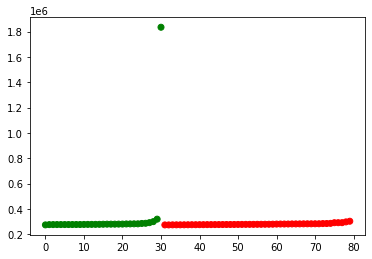

In [16]:
# Plot costs, red for infeasible solutions
population = algo.population
plt.scatter(range(len(population)), [indiv.cost for indiv in population], 
            c=['g' if indiv.isFeasible else 'r' for indiv in population])

(80, 80) 0.0 1.7903930131004366
[[0.         0.51965066 0.19213974 0.45851528 0.50218341]
 [0.51965066 0.         0.54148472 0.4650655  0.27947598]
 [0.19213974 0.54148472 0.         0.47816594 0.5       ]
 [0.46069869 0.46724891 0.48034934 0.         0.52401747]
 [0.5        0.27729258 0.49781659 0.51965066 0.        ]]


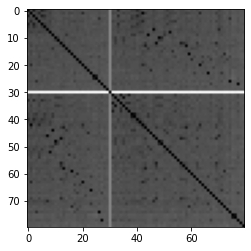

In [17]:
# Compute and plot pairwise similarity of all solutions in the population
all_broken_pairs_distance = np.array([
    [
        indiv1.brokenPairsDistance(indiv2)
        for indiv2 in population
    ]
    for indiv1 in population
])
print(all_broken_pairs_distance.shape, all_broken_pairs_distance.min(), all_broken_pairs_distance.max())
print(all_broken_pairs_distance[:5, :5])
plt.imshow(all_broken_pairs_distance, cmap='gray')

# Example: Neural Network based Crossover selection strategy

This section provides a very simple example of how to implement a variant of the genetic algorithm that uses a neural network to select which crossover to use in the local search.

Note that this is technically a working example, but it is not able to outperform the baseline due to its obvious limitations.

This part can also be seen as an example how the Python interface can be used to run parts of the algorithm seperately (i.e. the crossover, local search, etc.).

## Generate training data
First we generate training data by running the HGS algorithm for a limited time to 'warm up' the population. Then we will run the local search and repair procedure (local search with larger penalty) for all possible offsprings for a number of parent combinations. The result of the local search / repair (cost, feasibility and duration) is stored which can be used to train a model to predict these outcomes, such that we can guess which offspring is best to improve using local search.

In [18]:
# First, run the algorithm for a short time to get a reasonable population
params = hgspy.Params(config, **tools.inst_to_vars(instance))
algo = Genetic(params)
algo.run()
population = algo.population
best_py = population.getBestFound()

----- HasLargeRoutes: 0, HasLargeTW: 0
Added initial solution to population
Feas 1 1833647.00 1833647.00 | NO-INFEASIBLE | Div nan -1.00 | Feas 1.00 1.00 | Pen 394.67 1.00
Generated 5 individuals using Nearest
Feas 1 1833647.00 1833647.00 | Inf 5 283362.00 293017.40 | Div nan 0.63 | Feas 1.00 0.95 | Pen 394.67 1.00
Generated 5 individuals using Furthest
Feas 2 299023.00 1066335.00 | Inf 10 283362.00 296290.70 | Div 0.95 0.62 | Feas 1.00 0.90 | Pen 394.67 1.00
Generated 5 individuals using Sweep
Feas 3 291232.00 807967.33 | Inf 15 283362.00 295020.20 | Div 0.82 0.61 | Feas 1.00 0.85 | Pen 394.67 1.00
Generated 85 individuals Randomly
Feas 26 286526.00 297650.56 | Inf 57 283362.00 289525.56 | Div 0.59 0.56 | Feas 1.00 0.02 | Pen 394.67 1.00
It      0      2 | T(s) 4.13 | Feas 26 286526.00 297650.56 | Inf 58 283391.40 289269.67 | Div 0.59 0.56 | Feas 1.00 0.02 | Pen 335.47 1.20


In [19]:
# Define some helper functions to run the local search / repair (local search with larger penalty)
crossover = algo.crossover
local_search = algo.local_search
def do_local_search(indiv):
    # Note: run modifies indiv in place so create copy first
    result = copy(indiv)
    local_search.run(result, params.penaltyCapacity, params.penaltyTimeWarp)
    return result

def do_repair(indiv):
    # Note: run modifies indiv in place so create copy first
    result = copy(indiv)
    if not indiv.isFeasible:
        local_search.run(result, params.penaltyCapacity * 10, params.penaltyTimeWarp * 10)
    return result

reference_cost = best_py.cost
def get_relative_difference(indiv):
    return (indiv.cost - reference_cost) / reference_cost

In [20]:
# For a random number of random parent combinations, create all possible offsprings and
# run the local search for each one of them, as well as the repair and store the results/timings
n_datapoints = 100
parents = [
    population.get_non_identical_parents_binary_tournament()
    for i in range(n_datapoints)
]

data = []
for i, (parent1, parent2) in enumerate(parents):
    if (i + 1) % 10 == 0:
        print(f"{i+1}/{len(parents)}...")
    start = time.time()
    ox_offspring = crossover.OX(parent1, parent2)
    ox_duration = time.time() - start
    start = time.time()
    srex_offspring1, srex_offspring2 = crossover.SREX(parent1, parent2)
    srex_duration = time.time() - start

    row = {
        'parent1': parent1,
        'parent1_relcost': get_relative_difference(parent1),
        'parent1_feas': parent1.isFeasible,
        'parent1_fitness': parent1.biasedFitness,
        'parent2': parent2,
        'parent2_relcost': get_relative_difference(parent2),
        'parent2_feas': parent2.isFeasible,
        'parent2_fitness': parent2.biasedFitness,
        'parent_distance': parent1.brokenPairsDistance(parent2)
    }
    for name, (offspring, duration) in {
        'ox': (ox_offspring, ox_duration),
        'srex1': (srex_offspring1, srex_duration),
        'srex2': (srex_offspring2, srex_duration)
    }.items():
        t_start = time.time()
        result_ls = do_local_search(offspring)
        t_ls = time.time()
        result_repair = do_repair(result_ls)
        t_repair = time.time()
        
        row[f'{name}_result_cross'] = offspring
        row[f'{name}_result_ls'] = result_ls
        row[f'{name}_result_repair'] = result_repair
        row[f'{name}_relcost_cross'] = get_relative_difference(offspring)
        row[f'{name}_relcost_ls'] = get_relative_difference(result_ls)
        row[f'{name}_relcost_repair'] = get_relative_difference(result_repair)
        row[f'{name}_feas_cross'] = offspring.isFeasible
        row[f'{name}_feas_ls'] = result_ls.isFeasible
        row[f'{name}_feas_repair'] = result_repair.isFeasible
        row[f'{name}_time_cross'] = duration
        row[f'{name}_time_ls'] = t_ls - t_start
        row[f'{name}_time_repair'] = t_repair - t_ls
        row[f'{name}_time_total'] = t_repair - t_start + duration
        
    data.append(row)

data[0]

10/100...
20/100...
30/100...
40/100...
50/100...
60/100...
70/100...
80/100...
90/100...
100/100...


{'parent1': <hgspy.Individual at 0x11b614ef0>,
 'parent1_relcost': 0.08740698237132531,
 'parent1_feas': False,
 'parent1_fitness': 0.9767441860465116,
 'parent2': <hgspy.Individual at 0x1061f9030>,
 'parent2_relcost': 0.023502050981541168,
 'parent2_feas': True,
 'parent2_fitness': 0.9374634716540035,
 'parent_distance': 0.5982532751091703,
 'ox_result_cross': <hgspy.Individual at 0x11b605c30>,
 'ox_result_ls': <hgspy.Individual at 0x11cf8e5f0>,
 'ox_result_repair': <hgspy.Individual at 0x11cc825f0>,
 'ox_relcost_cross': 1.1812502378161929,
 'ox_relcost_ls': 0.031984324641078234,
 'ox_relcost_repair': 0.031984324641078234,
 'ox_feas_cross': False,
 'ox_feas_ls': True,
 'ox_feas_repair': True,
 'ox_time_cross': 6.890296936035156e-05,
 'ox_time_ls': 0.03310894966125488,
 'ox_time_repair': 3.504753112792969e-05,
 'ox_time_total': 0.033212900161743164,
 'srex1_result_cross': <hgspy.Individual at 0x1062008f0>,
 'srex1_result_ls': <hgspy.Individual at 0x106200c30>,
 'srex1_result_repair': <

In [21]:
df = pd.DataFrame(data)
# Filter when the very bad initial solution was selected as parent
df = df[(df['parent1_relcost'] < 1) & (df['parent2_relcost'] < 1)]
df

,parent1,parent1_relcost,parent1_feas,parent1_fitness,parent2,parent2_relcost,parent2_feas,parent2_fitness,parent_distance,ox_result_cross,...,srex2_relcost_cross,srex2_relcost_ls,srex2_relcost_repair,srex2_feas_cross,srex2_feas_ls,srex2_feas_repair,srex2_time_cross,srex2_time_ls,srex2_time_repair,srex2_time_total
0,<hgspy.Individual object at 0x11b614ef0>,0.087407,False,0.976744,<hgspy.Individual object at 0x1061f9030>,0.023502,True,0.937463,0.598253,<hgspy.Individual object at 0x11b605c30>,...,0.771138,0.061769,0.057508,False,False,True,0.000532,0.020564,0.017282,0.038378
1,<hgspy.Individual object at 0x11cf8e630>,0.029505,True,0.919345,<hgspy.Individual object at 0x1061f9030>,0.023502,True,0.937463,0.604803,<hgspy.Individual object at 0x106200ef0>,...,0.334201,0.015000,0.015056,False,False,True,0.000476,0.017652,0.007660,0.025788
2,<hgspy.Individual object at 0x11cf8e670>,0.000146,False,0.871036,<hgspy.Individual object at 0x11cf8e6b0>,0.031860,True,1.036528,0.572052,<hgspy.Individual object at 0x1062045b0>,...,0.157009,0.014968,0.015778,False,False,True,0.000258,0.010709,0.008408,0.019375
3,<hgspy.Individual object at 0x11cf8e6f0>,0.011042,True,0.542081,<hgspy.Individual object at 0x11cf8e730>,0.008991,True,0.857686,0.519651,<hgspy.Individual object at 0x106204bf0>,...,0.191347,0.009438,0.010995,False,False,True,0.000184,0.011552,0.007587,0.019323
4,<hgspy.Individual object at 0x11cf8e770>,0.021762,True,0.612507,<hgspy.Individual object at 0x11cf8e7b0>,0.013339,False,0.809725,0.593886,<hgspy.Individual object at 0x106206270>,...,0.357510,0.023940,0.023887,False,False,True,0.000287,0.014503,0.007347,0.022137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,<hgspy.Individual object at 0x106200330>,0.031266,True,0.969901,<hgspy.Individual object at 0x11cf8ea30>,0.011332,True,0.914085,0.576419,<hgspy.Individual object at 0x11cf40b70>,...,0.289421,0.008962,0.008962,False,True,True,0.000272,0.011213,0.000031,0.011516
96,<hgspy.Individual object at 0x11cf8e9b0>,0.019528,True,0.641146,<hgspy.Individual object at 0x106200870>,0.016331,True,1.085330,0.519651,<hgspy.Individual object at 0x11cf441f0>,...,0.607586,0.026187,0.026762,False,False,True,0.000393,0.012811,0.007901,0.021105
97,<hgspy.Individual object at 0x1062008b0>,0.022074,True,1.064874,<hgspy.Individual object at 0x11cf8eab0>,0.029376,False,0.900634,0.552402,<hgspy.Individual object at 0x11cf44830>,...,0.604919,0.027210,0.028212,False,False,True,0.000590,0.019603,0.008199,0.028392
98,<hgspy.Individual object at 0x1062002b0>,0.015902,True,0.794857,<hgspy.Individual object at 0x11cf8eaf0>,0.028764,False,0.919662,0.539301,<hgspy.Individual object at 0x11cf44e70>,...,0.318371,0.011262,0.011262,False,True,True,0.000223,0.008477,0.000018,0.008718


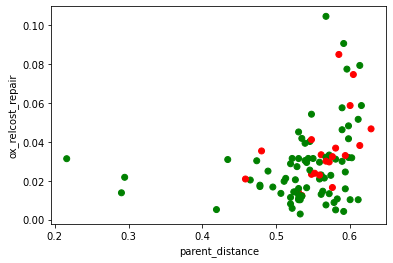

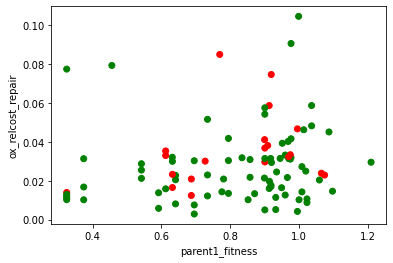

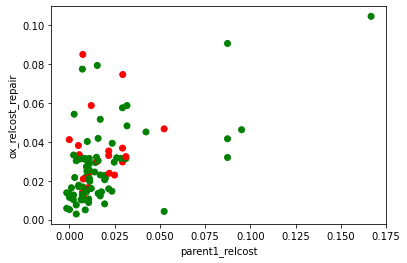

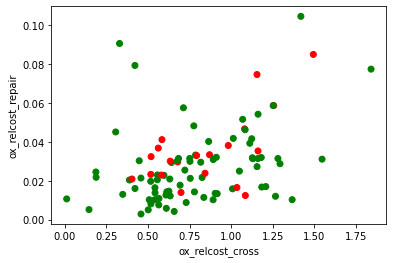

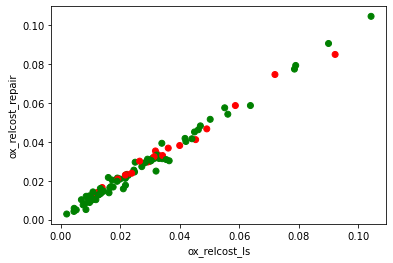

In [22]:
# Create scatter plots to analyze correlations
for name in ('ox', ): # ('ox', 'srex1', 'srex2'):
    y_name = f'{name}_relcost_repair'
    feas_color = ['g' if is_feas else 'r' for is_feas in df[f'{name}_feas_repair']]
    for x_name in ('parent_distance', 'parent1_fitness', 'parent1_relcost', f'{name}_relcost_cross', f'{name}_relcost_ls'):
        
        plt.scatter(df[x_name], df[y_name], c=feas_color)
        plt.xlabel(x_name)
        plt.ylabel(y_name)
        plt.show()

## Create model & datasets
The model is a simple two-layer neural network that will predict cost, feasibility and time for the local search / repair all at once, based on the cost of the offspring solutions before local search and the cost/feasibility/fitness of the parent solutions. We can than later define a strategy to choose which offspring to run based on the predicted values. We will use 10% of the data for validation.

In [23]:
# Inspect what columns we have
print(list(df.columns))

feature_names = [
    'parent1_relcost',
    'parent1_feas',
    'parent1_fitness',
    'parent2_relcost',
    'parent2_feas',
    'parent2_fitness',
    'parent_distance',
    'ox_relcost_cross',
    'ox_time_cross',
    'srex1_relcost_cross',
    'srex1_time_cross',
    'srex2_relcost_cross',
    'srex2_time_cross',
]

target_names = [
    'ox_relcost_ls',
    'ox_relcost_repair',
    'ox_feas_ls',
    'ox_feas_repair',
    'ox_time_ls',
    'ox_time_repair',
    'ox_time_total',
    'srex1_relcost_ls',
    'srex1_relcost_repair',
    'srex1_feas_ls',
    'srex1_feas_repair',
    'srex1_time_ls',
    'srex1_time_repair',
    'srex1_time_total',
    'srex2_relcost_ls',
    'srex2_relcost_repair',
    'srex2_feas_ls',
    'srex2_feas_repair',
    'srex2_time_ls',
    'srex2_time_repair',
    'srex2_time_total'
]

['parent1', 'parent1_relcost', 'parent1_feas', 'parent1_fitness', 'parent2', 'parent2_relcost', 'parent2_feas', 'parent2_fitness', 'parent_distance', 'ox_result_cross', 'ox_result_ls', 'ox_result_repair', 'ox_relcost_cross', 'ox_relcost_ls', 'ox_relcost_repair', 'ox_feas_cross', 'ox_feas_ls', 'ox_feas_repair', 'ox_time_cross', 'ox_time_ls', 'ox_time_repair', 'ox_time_total', 'srex1_result_cross', 'srex1_result_ls', 'srex1_result_repair', 'srex1_relcost_cross', 'srex1_relcost_ls', 'srex1_relcost_repair', 'srex1_feas_cross', 'srex1_feas_ls', 'srex1_feas_repair', 'srex1_time_cross', 'srex1_time_ls', 'srex1_time_repair', 'srex1_time_total', 'srex2_result_cross', 'srex2_result_ls', 'srex2_result_repair', 'srex2_relcost_cross', 'srex2_relcost_ls', 'srex2_relcost_repair', 'srex2_feas_cross', 'srex2_feas_ls', 'srex2_feas_repair', 'srex2_time_cross', 'srex2_time_ls', 'srex2_time_repair', 'srex2_time_total']


In [24]:
# Import torch and determine cuda availability
# (we do so here such that rest of notebook can be used without PyTorch)
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
print(torch.__version__)
if torch.cuda.device_count() > 0:
    print(torch.cuda.get_device_name(0))

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')
print(device)

1.12.0
cpu


In [25]:
# Define datasets
class MyDataset(Dataset):
 
    def __init__(self, dataframe, feature_names, target_names):
        self.features = torch.tensor(dataframe[feature_names].astype(float).to_numpy(), dtype=torch.float32)
        self.targets = torch.tensor(dataframe[target_names].astype(float).to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self,idx):
        return self.features[idx], self.targets[idx]

num_valid = int(0.1 * len(df))

train_dataset = MyDataset(df[:-num_valid], feature_names, target_names)
valid_dataset = MyDataset(df[-num_valid:], feature_names, target_names)
print(f"Train dataset size: {len(train_dataset)}, validation dataset size: {len(valid_dataset)}")

Train dataset size: 88, validation dataset size: 9


In [26]:
# Define simple two layer MLP that predicts all outputs at once

class MyModel(nn.Module):
    
    def __init__(self, num_inputs, num_outputs, num_hidden=64):
        super().__init__()
        self.layer1 = nn.Linear(num_inputs, num_hidden)
        self.layer2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, features):
        hidden = self.layer1(features)
        out = self.layer2(hidden)
        return out

model = MyModel(
    num_inputs=len(feature_names),
    num_outputs=len(target_names)
)
test_features = torch.rand(10, len(feature_names))
out = model(test_features)
print(out.shape) # (batch_size, num_outputs)

torch.Size([10, 21])


## Train model
As loss function, we will simply average the loss over all predictions, where we use mean squared error (MSE) loss for continues predictions (relative costs) and binary cross entropy loss for boolean predictions (feasibility). We train for a small number of epochs.

In [27]:
target_is_binary = torch.tensor(
    ['feas' in output_name for output_name in target_names], dtype=bool)

def compute_loss(model, features, targets):
    pred = model(features)
    # For binary targets, interpret predictions as logits and use binary xent
    losses = torch.where(
        target_is_binary[None],
        F.binary_cross_entropy_with_logits(pred, targets, reduction='none'),
        F.mse_loss(pred, targets, reduction='none')
    )
    # Take mean across different targets and batch
    return losses.mean(), losses.shape[0]

def train(model, loss_fn, device, train_loader, optimizer, epoch,
          log_interval=100, verbose=False):
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        features = features.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        loss, _ = loss_fn(model, features, targets)
        loss.backward()
        optimizer.step()
        if verbose and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def validate(model, loss_fn, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    dataset_size = 0
    with torch.no_grad():
        for features, targets in valid_loader:
            features = features.to(device)
            targets = targets.to(device)
            batch_loss, batch_size = loss_fn(model, features, targets)
            valid_loss += batch_loss * batch_size
            dataset_size += batch_size

    valid_loss /= dataset_size

    print('\nValidation set: Average loss: {:.4f}\n'.format(
        valid_loss))

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1000, shuffle=False)


learning_rate = 1e-3
weight_decay = 0 # Set to > 0 to regularize weights to avoid overfitting

torch.manual_seed(42)
model = MyModel(num_inputs=len(feature_names), num_outputs=len(target_names), num_hidden=128)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
                       weight_decay=weight_decay)

print("Training...")
validate(model, compute_loss, device, valid_dataloader)
num_epochs = 100
for epoch in range(num_epochs):
    train(model, compute_loss, device, train_dataloader, optimizer, epoch, 
          verbose=epoch % 10 == 0)
    if epoch % 10 == 0:
        validate(model, compute_loss, device, valid_dataloader)
        
model_filename = 'model.pth'
print(f"Save model to {model_filename}")
torch.save(model.state_dict(), model_filename)

Training...

Validation set: Average loss: 0.2577

Train Epoch: 0 [0/88 (0%)]	Loss: 0.250288

Validation set: Average loss: 0.1931

Train Epoch: 10 [0/88 (0%)]	Loss: 0.104460

Validation set: Average loss: 0.1606

Train Epoch: 20 [0/88 (0%)]	Loss: 0.105836

Validation set: Average loss: 0.1594

Train Epoch: 30 [0/88 (0%)]	Loss: 0.126433

Validation set: Average loss: 0.1564

Train Epoch: 40 [0/88 (0%)]	Loss: 0.117148

Validation set: Average loss: 0.1551

Train Epoch: 50 [0/88 (0%)]	Loss: 0.108148

Validation set: Average loss: 0.1551

Train Epoch: 60 [0/88 (0%)]	Loss: 0.102556

Validation set: Average loss: 0.1546

Train Epoch: 70 [0/88 (0%)]	Loss: 0.164455

Validation set: Average loss: 0.1550

Train Epoch: 80 [0/88 (0%)]	Loss: 0.115486

Validation set: Average loss: 0.1546

Train Epoch: 90 [0/88 (0%)]	Loss: 0.111607

Validation set: Average loss: 0.1551

Save model to model.pth


## Evaluate model
We can evaluate how well the model is able to predict the targets (e.g. the relative cost of the offspring solution after local search) by plotting the predictions vs the actual values.

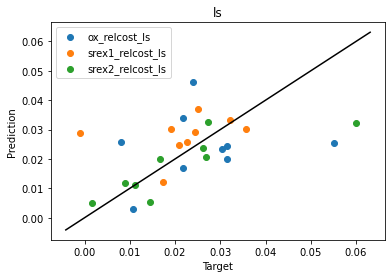

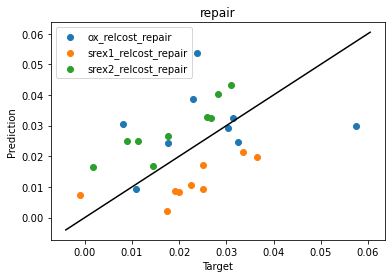

In [28]:
# Make predictions on validation set
model.eval()
valid_loss = 0
correct = 0
dataset_size = 0
with torch.no_grad():
    for features, targets in valid_dataloader:

        features = features.to(device)
        targets = targets.to(device)
        out = model(features)
        preds = torch.where(target_is_binary, torch.sigmoid(out), out)
        break


# Plot prediction vs actual for relcost of different crossovers
# after local search and repair phase on the validation set
for phase in ('ls', 'repair'):
    for target_name, pred, target in zip(target_names, preds.t(), targets.t()):
        if 'relcost' in target_name and target_name.endswith(phase):
            plt.scatter(target.tolist(), pred.tolist(), label=target_name)
    plt.legend()
    plt.title(phase)
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    ax = plt.gca()
    minx, maxx = ax.get_xlim()
    miny, maxy = ax.get_ylim()
    minxy, maxxy = min(minx, miny), max(maxx, maxy)
    plt.plot([minxy, maxxy], [minxy, maxxy], c='black')
    plt.show()

## Use model inside custom genetic algorithm
Now we will implement a custom version of the Genetic algorithm that uses the model to predict which crossover will yield the best result and run the local search on the offspring for that crossover. We will evaluate the result on a different (test) instance using a few different seeds. Note: the current implementation does not improve the baseline as the model is very weak.

In [29]:
# Define custom genetic algorithm implementation that uses model
# to predict which crossover will yield the best result and run
# the local search on the offspring for that crossover

class CustomGenetic(Genetic):

    def __init__(self, *args, **kwargs):
        
        self.model = kwargs.pop('model')
        self.device = kwargs.pop('device', 'cpu')
        self.feature_names = kwargs.pop('feature_names')
        self.target_names = kwargs.pop('target_names')
        
        super().__init__(*args, **kwargs)

        self.model.eval()
        self.model.to(self.device)

        # pred_idx = [1, 8, 15]
        self.pred_idx = torch.tensor([
            i for i, target_name in enumerate(self.target_names)
            if target_name.endswith("relcost_repair")
        ], dtype=torch.long, device=self.device)
        # pred_crossover_names = ['ox', 'srex1', 'srex2']
        self.pred_crossover_names = [
            self.target_names[i].split("_")[0]  # Crossover name
            for i in self.pred_idx
        ]

    def get_raw_offspring_data(self):
        # Note: this mimics the training set data generation procedure

        best = self.population.getBestFound()
        reference_cost = best.cost
        def get_relative_difference(indiv):
            return (indiv.cost - best.cost) / best.cost

        parent1, parent2 = self.population.get_non_identical_parents_binary_tournament()

        start = time.time()
        ox_offspring = self.crossover.OX(parent1, parent2)
        ox_duration = time.time() - start
        start = time.time()
        srex_offspring1, srex_offspring2 = self.crossover.SREX(parent1, parent2)
        srex_duration = time.time() - start

        row = {
            'parent1': parent1,
            'parent1_relcost': get_relative_difference(parent1),
            'parent1_feas': parent1.isFeasible,
            'parent1_fitness': parent1.biasedFitness,
            'parent2': parent2,
            'parent2_relcost': get_relative_difference(parent2),
            'parent2_feas': parent2.isFeasible,
            'parent2_fitness': parent2.biasedFitness,
            'parent_distance': parent1.brokenPairsDistance(parent2)
        }
        for name, (offspring, duration) in {
            'ox': (ox_offspring, ox_duration),
            'srex1': (srex_offspring1, srex_duration),
            'srex2': (srex_offspring2, srex_duration)
        }.items():
            row[f'{name}_result_cross'] = offspring
            row[f'{name}_relcost_cross'] = get_relative_difference(offspring)
            row[f'{name}_time_cross'] = duration

        return row

    def get_offspring(self, num_tries=5):
        
        # Generate multiple offspring and extract raw data
        data = [self.get_raw_offspring_data() for i in range(num_tries)]

        # Extract features
        features = torch.tensor(
            [[row[k] for k in self.feature_names] for row in data], 
            dtype=torch.float32, device=self.device)

        # Make predictions in batch and extract relevant predicted values
        preds = self.model(features)[:, self.pred_idx]

        # Take best best crossover method for each try, then take best try
        best_preds, best_method_idx_per_try = preds.min(dim=-1)
        best_try = best_preds.argmin()
        best_method = self.pred_crossover_names[best_method_idx_per_try[best_try]]
        
        # Take name of prediction with lowest (= best) value
        return data[best_try][f'{best_method}_result_cross']

custom_genetic = CustomGenetic(params,
    model=model, device=device,
    feature_names=feature_names, target_names=target_names)

custom_genetic.run()

Added initial solution to population
Feas 1 1833647.00 1833647.00 | NO-INFEASIBLE | Div nan -1.00 | Feas 1.00 1.00 | Pen 206.02 1.73
Generated 5 individuals using Nearest
Feas 3 288458.00 807064.33 | Inf 5 284044.00 294576.00 | Div 0.83 0.61 | Feas 1.00 0.95 | Pen 206.02 1.00
Generated 5 individuals using Furthest
Feas 4 288458.00 677470.75 | Inf 10 284044.00 296874.10 | Div 0.79 0.62 | Feas 1.00 0.90 | Pen 206.02 1.00
Generated 5 individuals using Sweep
Feas 4 288458.00 677470.75 | Inf 15 284044.00 295264.73 | Div 0.79 0.61 | Feas 1.00 0.85 | Pen 206.02 1.00
Generated 85 individuals Randomly
Feas 29 287313.00 296810.40 | Inf 56 284044.00 290305.96 | Div 0.59 0.56 | Feas 0.99 0.03 | Pen 206.02 1.00
It      0      2 | T(s) 3.96 | Feas 29 287313.00 296810.40 | Inf 57 284081.20 290077.45 | Div 0.59 0.56 | Feas 0.98 0.03 | Pen 175.12 1.20


In [30]:
# We can load the model from the weights file like this
model = MyModel(num_inputs=len(feature_names), num_outputs=len(target_names), num_hidden=128)
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Create class that binds trained model
GeneticWithModel = functools.partial(CustomGenetic, 
    model=model, device=device,
    feature_names=feature_names, target_names=target_names)

# Test new algorithm on a different instance
test_instance = tools.read_vrplib(os.path.join('instances', 'ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12.txt'))
# Trivial initial solution: one route per request
test_initial_solution = [[i] for i in range(1, test_instance['coords'].shape[0])]

# Try both versions
results_per_method = {}
for genetic_cls in (GeneticWithModel, Genetic):
    results_method = []
    for seed in (1234, 1235, 1236, 1237, 1238):    

        # Define configuration
        test_config = hgspy.Config(
            seed=seed, 
            nbVeh=-1,
            timeLimit=30,
            useWallClockTime=True,
            initialSolution=to_giant_tour_str(test_initial_solution),
            useDynamicParameters=True)

        # Convert instance so it is suitable for HGS and define params object
        test_params = hgspy.Params(test_config, **tools.inst_to_vars(test_instance))

        # Create and run genetic algorithm
        test_algo = genetic_cls(test_params)
        test_algo.run()
        best = test_algo.population.getBestFound()

        results_method.append(int(best.cost))
        print("-" * 40)
        print(f"{test_algo.__class__.__name__} with seed {seed} found solution with cost {int(best.cost)} and feasible: {best.isFeasible}")
        print("-" * 40)
    results_per_method[test_algo.__class__.__name__] = results_method
print(results_per_method)
print({k: np.mean(v) for k, v in results_per_method.items()})

----- HasLargeRoutes: 0, HasLargeTW: 0
Added initial solution to population
Feas 1 933207.00 933207.00 | NO-INFEASIBLE | Div nan -1.00 | Feas 1.00 1.00 | Pen 273.79 1.00
Generated 5 individuals using Nearest
Feas 5 125526.00 290052.80 | Inf 5 125336.00 129302.80 | Div 0.72 0.57 | Feas 1.00 0.95 | Pen 273.79 1.00
Generated 5 individuals using Furthest
Feas 7 125526.00 243707.71 | Inf 9 121963.00 128120.56 | Div 0.67 0.55 | Feas 1.00 0.91 | Pen 273.79 1.00
Generated 5 individuals using Sweep
Feas 8 125526.00 229012.00 | Inf 13 121014.00 126670.15 | Div 0.67 0.54 | Feas 1.00 0.87 | Pen 273.79 1.00
Generated 85 individuals Randomly
Feas 51 123440.00 126090.32 | Inf 37 120724.00 124661.52 | Div 0.50 0.50 | Feas 1.00 0.22 | Pen 273.79 1.00
It      0      2 | T(s) 1.38 | Feas 52 123440.00 125957.96 | Inf 37 120724.00 124661.52 | Div 0.50 0.50 | Feas 1.00 0.23 | Pen 232.72 1.00
It    500     16 | T(s) 4.32 | Feas 26 114692.00 115116.44 | Inf 48 114830.24 115151.08 | Div 0.18 0.14 | Feas 1.00 0

Generated 5 individuals using Nearest
Feas 2 131145.00 532176.00 | Inf 4 122000.00 127180.00 | Div 0.95 0.55 | Feas 1.00 0.96 | Pen 273.79 1.00
Generated 5 individuals using Furthest
Feas 3 128629.00 397660.33 | Inf 8 122000.00 126826.88 | Div 0.82 0.54 | Feas 1.00 0.92 | Pen 273.79 1.00
Generated 5 individuals using Sweep
Feas 5 124277.00 290382.00 | Inf 13 122000.00 127266.85 | Div 0.72 0.55 | Feas 1.00 0.87 | Pen 273.79 1.00
Generated 85 individuals Randomly
Feas 58 121223.00 125809.04 | Inf 42 121022.00 124866.12 | Div 0.50 0.51 | Feas 1.00 0.17 | Pen 273.79 1.00
It      0      2 | T(s) 1.39 | Feas 59 121223.00 125539.60 | Inf 42 121022.00 124866.12 | Div 0.49 0.51 | Feas 1.00 0.18 | Pen 232.72 1.00
It    500     25 | T(s) 4.23 | Feas 57 115436.00 115622.12 | Inf 58 115115.27 115479.26 | Div 0.17 0.23 | Feas 1.00 0.28 | Pen 103.26 0.52
It   1000     33 | T(s) 6.88 | Feas 63 114178.00 114460.68 | Inf 59 114078.71 114354.73 | Div 0.09 0.10 | Feas 0.95 0.09 | Pen 45.82 1.53
It   1500 

It    500     16 | T(s) 4.77 | Feas 36 115522.00 116736.36 | Inf 26 115259.02 116899.47 | Div 0.41 0.43 | Feas 0.86 0.17 | Pen 103.26 1.02
It   1000      6 | T(s) 7.56 | Feas 33 114714.00 115478.84 | Inf 47 114524.65 114938.69 | Div 0.39 0.32 | Feas 0.64 0.26 | Pen 45.82 0.87
It   1500     94 | T(s) 10.36 | Feas 54 114209.00 114659.44 | Inf 39 113901.08 114730.58 | Div 0.28 0.37 | Feas 0.46 0.18 | Pen 20.33 0.87
It   2000    201 | T(s) 13.40 | Feas 35 114007.00 114739.72 | Inf 61 113895.92 114127.67 | Div 0.35 0.29 | Feas 0.29 0.27 | Pen 10.61 1.27
It   2500    186 | T(s) 16.29 | Feas 65 113758.00 114105.32 | Inf 65 113763.36 114014.44 | Div 0.22 0.25 | Feas 0.25 0.15 | Pen 5.54 1.56
It   3000    686 | T(s) 19.19 | Feas 26 113758.00 114146.96 | Inf 35 113414.40 113759.27 | Div 0.29 0.24 | Feas 0.34 0.51 | Pen 2.89 1.38
It   3500   1186 | T(s) 22.06 | Feas 44 113758.00 113823.04 | Inf 32 113363.89 113648.16 | Div 0.13 0.24 | Feas 0.32 0.19 | Pen 1.78 1.41
It   4000   1686 | T(s) 24.80 |

It   4000    266 | T(s) 24.30 | Feas 46 114075.00 114437.48 | Inf 59 113782.55 114035.41 | Div 0.27 0.28 | Feas 0.21 0.17 | Pen 4.71 1.38
It   4500    205 | T(s) 27.13 | Feas 43 114012.00 114243.80 | Inf 41 113678.29 113948.54 | Div 0.22 0.29 | Feas 0.25 0.17 | Pen 2.46 1.41
It   5000    197 | T(s) 29.84 | Feas 34 113958.00 114126.32 | Inf 58 113600.76 113817.23 | Div 0.24 0.25 | Feas 0.32 0.20 | Pen 1.09 1.20
----------------------------------------
Genetic with seed 1238 found solution with cost 113958 and feasible: True
----------------------------------------
{'CustomGenetic': [114593, 114513, 114361, 113990, 114408], 'Genetic': [113826, 113670, 113695, 113616, 113958]}
{'CustomGenetic': 114373.0, 'Genetic': 113753.0}


## Ideas
* Experiment with number of offsprings from which to select best for local search
* Train on different/multiple instances
* Add more advanced features (e.g. properties of the solutions)
* Improve model, e.g. use graph neural network, more layers, etc.